In [1]:
#imports
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import Sequential
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
seed_value = 2020
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
#utils functions
def midPrice(lob_data):
    a=lob_data['AP1'].values.tolist()
    b=lob_data['BP1'].values.tolist()
    m=np.zeros(len(a))
    for i in range(len(a)):
        m[i]=(a[i]+b[i])/2
    return m
def upDown(m):
    u_d=np.zeros(len(a))
    for i in range(1,len(a)):
        if m[i-1]>m[i]:#scende il prezzo
            u_d[i-1]=-1
        elif m[i-1]<m[i]:#sale il prezzo
            u_d[i-1]=1
        else:
            u_d[i-1]=0
    return u_d

def ret(m):
    r=np.zeros(len(m))
    for i in range(1,len(m)):
        r[i]=m[i-1]-m[i]
    return r

def deltaT(m):
    N=0
    d=np.zeros(len(m))
    for i in range(1,len(m)):
        d[i]=m[i-1]-m[i]
        if [i]!=0:
            N+=1
    return int((2.34*10**7)/N)

def doHk(deltT,k):
    hk=np.zeros(k)
    for i in range(k):
        hk[i]=np.int16((1/5)*i*deltT)
    return hk

def retHk(m,hk):
    ret=np.zeros(100)
    for i,k in zip(range(len(m)),hk):
        ret[i]=m[i+k]-m[i]
    return ret

def OF_1(ld):
    of=np.zeros((len(ld),6))
    for i,ii in zip(range(1,12,2),range(0,6,2)): #giro sui prezzi ask e volumi ask di conseguenza
        for j in range(1,len(ld)): #giro sulle righe
            #ask
            if ld[j][i-1]>ld[j-1][i-1]: #p_t>p_t-1
                of[j-1][ii]=-1*ld[j][i]
            elif ld[j][i-1]<ld[j-1][i-1]: #p_t<p_t-1
                of[j-1][ii]=ld[j][i]
            elif ld[j][i-1]==ld[j-1][i-1]: #p_t=p_t-1
                of[j-1][ii]=ld[j][i]-ld[j-1][i]
    for w,ww in zip(range(3,12,4),range(1,7,2)):
        for jj in range(1,len(ld)):    
            #bid
            if ld[jj][w-1]>ld[jj-1][w-1]: #p_t>p_t-1
                of[jj-1][ww]=ld[jj][w]
            elif ld[jj][w-1]<ld[jj-1][w-1]: #p_t<p_t-1
                of[jj-1][ww]=-1*ld[jj][w]
            elif ld[jj][w-1]==ld[jj-1][w-1]: #p_t=p_t-1
                of[jj-1][ww]=ld[jj][w]-ld[jj-1][w]
    return of

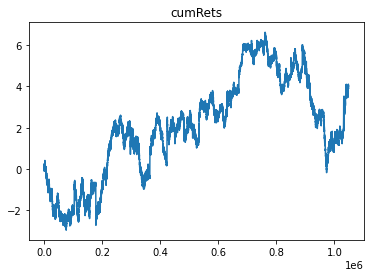

In [3]:
#load data e fa midprice/diff cum
lob_data=pd.read_csv('/Users/macri/Desktop/out_1.csv') #out_1 out_Nuovo
lob_data.reset_index(drop=True,inplace=True)
lob_data.drop(['index'], axis=1,inplace=True)
C= int(len(lob_data)*1)
b=lob_data.iloc[ :C].copy()
ld=b.values.tolist()
lob_data=b
ld=lob_data.values.tolist()
aa=OF_1(ld) #fa Order Flow
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(aa, columns=bCols)
m=pd.DataFrame(midPrice(lob_data),columns=['m'])#.plot()
m['r']=m['m'].diff()#calcola le differenze di midprice ogni 10 eventi ->differenze secondo il vettore h_K
m['rCum']=m['r'].cumsum()
of_data['r']=m['rCum']#*100
of_data.dropna(inplace=True)
of_data['r'].plot()
plt.title('cumRets')
plt.show()

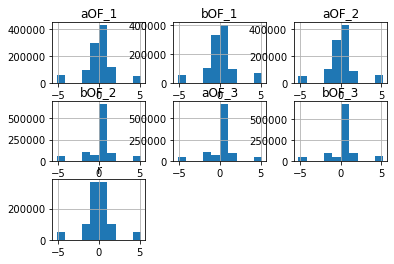

In [4]:
#normalizza e taglia al 0.005 e 99.995
x1=of_data['aOF_1']
x2=of_data['bOF_1']
x3=of_data['aOF_2']
x4=of_data['bOF_2']
x5=of_data['aOF_3']
x6=of_data['bOF_3']
x7=of_data['r'    ]
UPPERBOUND , LOWERBOUND =np.percentile(x1, [5,95])
UPPERBOUND1, LOWERBOUND1=np.percentile(x2, [5,95])
UPPERBOUND2, LOWERBOUND2=np.percentile(x3, [5,95])
UPPERBOUND3, LOWERBOUND3=np.percentile(x4, [5,95])
UPPERBOUND4, LOWERBOUND4=np.percentile(x5, [5,95])
UPPERBOUND5, LOWERBOUND5=np.percentile(x6, [5,95])
UPPERBOUND6, LOWERBOUND6=np.percentile(x7, [5,95])
x1Per=np.clip(x1,UPPERBOUND ,LOWERBOUND )
x2Per=np.clip(x2,UPPERBOUND1,LOWERBOUND1)
x3Per=np.clip(x3,UPPERBOUND2,LOWERBOUND2)
x4Per=np.clip(x4,UPPERBOUND3,LOWERBOUND3)
x5Per=np.clip(x5,UPPERBOUND4,LOWERBOUND4)
x6Per=np.clip(x6,UPPERBOUND5,LOWERBOUND5)
x7Per=np.clip(x7,UPPERBOUND6,LOWERBOUND6)


aOF_1_per= normalizer.fit_transform((x1Per.values.reshape(-1,1))).flatten().tolist()
bOF_1_per= normalizer.fit_transform((x2Per.values.reshape(-1,1))).flatten().tolist()
aOF_2_per= normalizer.fit_transform((x3Per.values.reshape(-1,1))).flatten().tolist()
bOF_2_per= normalizer.fit_transform((x4Per.values.reshape(-1,1))).flatten().tolist()
aOF_3_per= normalizer.fit_transform((x5Per.values.reshape(-1,1))).flatten().tolist()
bOF_3_per= normalizer.fit_transform((x6Per.values.reshape(-1,1))).flatten().tolist()
r_per    = normalizer.fit_transform((x7Per.values.reshape(-1,1))).flatten().tolist()

data = {'aOF_1': aOF_1_per,
        'bOF_1': bOF_1_per,
        'aOF_2': aOF_2_per,
        'bOF_2': bOF_2_per,
        'aOF_3': aOF_3_per,
        'bOF_3': bOF_3_per,
        'r'    : r_per    
        }

offlo=pd.DataFrame(data)
offlo.dropna(inplace=True)
offlo.hist()
plt.show()

In [5]:
#fa dataset
y=of_data['r'].to_numpy()
idx=10000
r=np.empty((idx,10))
h=[ 22, 44, 89, 133, 178, 223, 267, 312, 356, 401]

for i in range(idx): #righe
    for ii,iii in zip(range(10),h): #colonne, steps
        r[i,ii]=y[i+iii]-y[i]
#potrebbe essere che devi normalizzare il vettore (n,10)

x_vec=of_data[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][:1000000]
x=x_vec.to_numpy()
x_vecc=x.reshape(-1,100, 6,1)

r.shape, x_vecc.shape

((10000, 10), (10000, 100, 6, 1))

In [6]:
#fa supervised dataset: train, val e test
l=len(x_vecc)
a=int(l*0.6)
b=int(l*0.39)
x_vecc_train=x_vecc[:a]
r_train     =r[:a]
x_vecc_val  =x_vecc[a:a+b]
r_val       =r[a:a+b]
x_vecc_test =x_vecc[a+b:a+b+1]
r_test      =r[a+b:a+b+1]
print(x_vecc_train.shape, r.shape)
print(x_vecc_val.shape,   r_val.shape)
print(x_vecc_test.shape,  r_test.shape)


(6000, 100, 6, 1) (10000, 10)
(3900, 100, 6, 1) (3900, 10)
(1, 100, 6, 1) (1, 10)


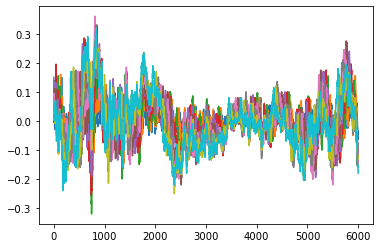

In [7]:
#check visivo se white noise
plt.plot(r_train)
plt.show()

In [25]:
#architettura della rete
num_units = 64
activation_function = 'leaky_relu'
adam = keras.optimizers.Adam(learning_rate=0.0001)
loss_function = 'mse'
batch_size = 256
num_epochs = 50
i = Input(shape=(100, 6))
x = LSTM(64, return_sequences=True)(i)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = keras.layers.Dropout(0.7)(x, training=True)
#x = LSTM(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(10, activation='leaky_relu')(x)


model = Model(i, x)


callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

model.compile(optimizer = adam, loss = loss_function)

r=model.fit(x_vecc_train, r_train, batch_size = batch_size, epochs = num_epochs,validation_data=(x_vecc_val, r_val),callbacks=[callback])

Epoch 1/50
24/24 [==============================] - 17s 615ms/step - loss: 0.2480 - val_loss: 0.1410
Epoch 2/50
24/24 [==============================] - 14s 593ms/step - loss: 0.0668 - val_loss: 0.0431
Epoch 3/50
24/24 [==============================] - 14s 569ms/step - loss: 0.0219 - val_loss: 0.0219
Epoch 4/50
24/24 [==============================] - 13s 558ms/step - loss: 0.0137 - val_loss: 0.0169
Epoch 5/50
24/24 [==============================] - 13s 540ms/step - loss: 0.0111 - val_loss: 0.0149
Epoch 6/50
24/24 [==============================] - 13s 544ms/step - loss: 0.0100 - val_loss: 0.0138
Epoch 7/50
24/24 [==============================] - 13s 552ms/step - loss: 0.0094 - val_loss: 0.0131
Epoch 8/50
24/24 [==============================] - 13s 539ms/step - loss: 0.0090 - val_loss: 0.0128
Epoch 9/50
24/24 [==============================] - 13s 544ms/step - loss: 0.0088 - val_loss: 0.0126
Epoch 10/50
24/24 [==============================] - 13s 543ms/step - loss: 0.0087 - val_lo

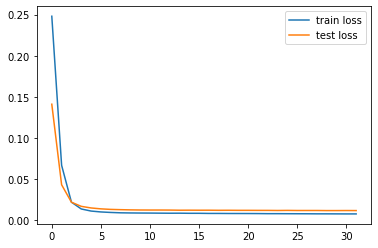

In [26]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [27]:
Ptrain= model.predict(x_vecc_train)
Ptest = model.predict(x_vecc_test)

1/1 [==============================] - 0s 16ms/step


In [28]:
y_pred_test =normalizer.inverse_transform(Ptest.reshape(-1,1))
y_true_test =normalizer.inverse_transform(r_test.reshape(-1,1))
y_pred_train=normalizer.inverse_transform(Ptrain.reshape(-1,1))
y_true_train=normalizer.inverse_transform(r_train.reshape(-1,1))

In [29]:
def calcola_mse(y_true,y_pred):
    mse=(y_true-y_pred)**2/y_true**2
    return mse

In [30]:
a=1-calcola_mse(r_test,Ptest)

In [31]:
a

array([[  0.42180369,   0.99953347,   0.40033528,  -2.70805261,
         -2.42684008,  -1.17469492, -38.59908422, -10.46315072,
         -0.26068941,  -1.23600219]])

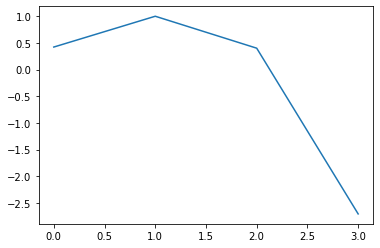

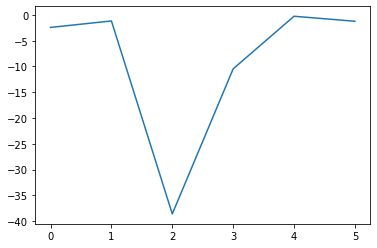

In [32]:
plt.plot(a[0][:4])
plt.show()
plt.plot(a[0][4:])
plt.show()